# PBO against LQR
## Define environment

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


max_state = 9
max_action = 11

env = LinearQuadraticEnv(max_state=max_state, max_action=max_action)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Transition: s' = As + Ba
Transition: s' = 0.76s + -3.54a
Reward: Qs² + Ra² + 2 Ssa
Reward: -4.55s² + 3.32a² + -2.68sa


## Data collection

In [7]:
from pbo.data_collection.replay_buffer import ReplayBuffer


n_samples = 100
epsilon_greedy = 0.4
max_episode_length = 3

replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

while idx_sample < n_samples:
    if np.random.random() < epsilon_greedy:
        action = env.optimal_action()
    else:
        action = np.random.uniform(-max_action, max_action, size=1)
    next_state, reward, _, _ = env.step(action)

    replay_buffer.add(state, action, np.array([reward]), next_state)

    epidose_length += 1
    idx_sample += 1

    if epidose_length >= max_episode_length:
        state = env.reset()
        epidose_length = 0
    else:    
        state = next_state


## Visualize samples

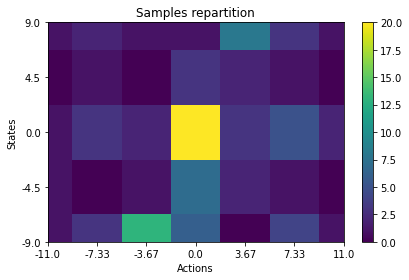

In [8]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


n_discrete_states = 5
n_discrete_actions = 7

samples_count = count_samples(replay_buffer, max_state, n_discrete_states, max_action, n_discrete_actions)
samples_visualization_mesh = StateActionMesh(max_state, n_discrete_states, max_action, n_discrete_actions, sleeping_time=0)

samples_visualization_mesh.set_values(samples_count)
samples_visualization_mesh.show("Samples repartition")

In [9]:
from pbo.data_collection.dataloader import DataLoader


batch_size = 8
    
data_loader = DataLoader(replay_buffer, batch_size)

## Building networks

In [10]:
from pbo.agents.q_networks import QFullyConnectedNet
from pbo.agents.pbo_networks import LinearPBONet

layer_dimension = 3
random_weights_range = 10
gamma = 0.99

Q_network = QFullyConnectedNet(
    layer_dimension=layer_dimension,
    random_weights_range=random_weights_range,
    max_action=max_action,
    n_discrete_actions=n_discrete_actions,
)
PBO = LinearPBONet(gamma=gamma, q_weights_dimensions=Q_network.q_weights_dimensions)


## The goal: optimal Q function

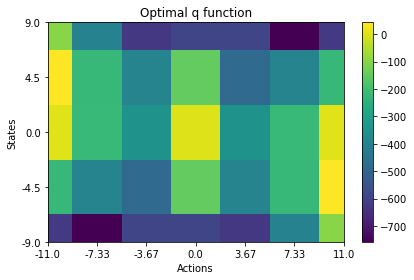

In [11]:
from pbo.utils.compute_Q_lqr import compute_Q_lqr


sleeping_time = 0.1

optimal_Q = compute_Q_lqr(env, n_discrete_states, n_discrete_actions, gamma)

q_funcions_visualization_mesh = StateActionMesh(max_state, n_discrete_states, max_action, n_discrete_actions, sleeping_time)

q_funcions_visualization_mesh.set_values(optimal_Q)
q_funcions_visualization_mesh.show("Optimal q function")

## Training

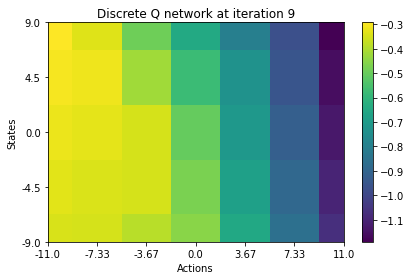

In [12]:
n_iteration = 10

for iteration in range(n_iteration):
    random_weights = Q_network.get_random_weights()

    for batch in data_loader:
        PBO.learn_on_batch(batch, random_weights, Q_network)
    
    # Plot the fixed point Q network
    Q_network.set_weights(PBO.get_fixed_point())
    discrete_Q_network = Q_network.get_discrete_Q(max_state, n_discrete_states)
    
    q_funcions_visualization_mesh.set_values(discrete_Q_network)
    q_funcions_visualization_mesh.show(f"Discrete Q network at iteration {iteration}")
    